<a href="https://colab.research.google.com/github/Brotherswords/DeepLearning_Project/blob/main/CSCI4931_WUN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Brian H., Jake M., Lavan V., Matthew W.
# CSCI 4931 - Deep Learning Final Project
# Wave-U-Net ح

In [ ]:
# Environment
!pip install librosa tensorflow
!pip install tensorflow

In [ ]:
!pip install tensorflow

In [1]:
# Wave-U-Net Model
import tensorflow as tf
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling1D
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Concatenate, Normalization, BatchNormalization

In [2]:
print(tf.__version__)

2.12.0


In [3]:
# mount Google Drive to the Colab VM
from google.colab import drive
import os
import zipfile

# drive.mount('/content/drive')

# Mount Google Drive
drive.mount('/content/drive')

# Replace 'YourFolderName' with the name of your folder
folder_path = '/content/drive/My Drive/datasets/DSD100.zip'

# # List all files in the directory -> use this to figure out the exact
# for file in os.listdir(folder_path):
#     print(file)
print("Mounted Successfully")


Mounted at /content/drive
Mounted Successfully


In [4]:
import zipfile

# Path to the zip file
# Its not Gojover yet
# Path to the DSD100 zip file
zip_file_path = '/content/drive/My Drive/datasets/DSD100.zip'

# Function to process the zip file
mixtures_dict = {}
sources_dict = {}

# Function to process the zip file
def process_dsd100_zip(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if 'Mixtures/Test/' in file and file.endswith('mixture.wav'):
                key = file.split('/')[-2]  # Extract song key
                # print(key)
                mixtures_dict[key] = file
            elif 'Sources/Test/' in file and file.endswith(('.wav')):
                key = file.split('/')[-2]  # Extract song key
                if key not in sources_dict:
                    sources_dict[key] = []
                sources_dict[key].append(file)


# Process the DSD100 zip file
process_dsd100_zip(zip_file_path)

# Create Mixtures and Sources lists
Mixtures = []
Sources = []

for key, mixture_path in mixtures_dict.items():
    Mixtures.append(mixture_path)
    Sources.append(sources_dict.get(key, []))  # Get the sources, or an empty list if not found

# Displaying the first few paths for verification
print("First mixture:", Mixtures[0])
print("First source tuple:", Sources[0])


# # Open the zip file and list its contents
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     for file in zip_ref.namelist():
#         print(file)

First mixture: DSD100/Mixtures/Test/050 - Zeno - Signs/mixture.wav
First source tuple: ['DSD100/Sources/Test/050 - Zeno - Signs/vocals.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/other.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/drums.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/bass.wav']


In [5]:
#Play the music to show that it is working
from IPython.display import Audio

def extract_and_play(file_path_in_zip):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        if file_path_in_zip in zip_ref.namelist():
            # Create a complete path for extraction
            filename = os.path.basename(file_path_in_zip)
            temp_path = '/tmp/' + filename
            # Extract the file
            zip_ref.extract(file_path_in_zip, '/tmp/')
            extracted_file_path = os.path.join('/tmp/', file_path_in_zip)
            print(f"Extracted to: {extracted_file_path}")

            # Check if the file exists at the extracted path
            if os.path.exists(extracted_file_path):
                print(extracted_file_path)
                return Audio(filename=extracted_file_path)
            else:
                print("Extracted file not found.")
                return None
        else:
            print("File not found in the zip archive.")
            return None

if Mixtures:
    audio_widget = extract_and_play(Mixtures[0])
    if audio_widget is not None:
        print("Valid audio widget")
        display(audio_widget)
    else:
        print("Audio_widget is none")
else:
    print("Mixtures list is empty.")

Extracted to: /tmp/DSD100/Mixtures/Test/050 - Zeno - Signs/mixture.wav
/tmp/DSD100/Mixtures/Test/050 - Zeno - Signs/mixture.wav
Valid audio widget


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.ops.gen_nn_ops import BatchNormWithGlobalNormalizationGrad
# Wave-U-Net: 1D Audio Processing
# Based on U-Net, using downsampling and upsampling blocks

def BasicWaveUNet(input_shape=(None, 1), num_filters=[16, 32, 64, 128, 256, 512], filter_length=15):

    #input shape parameters
    batch_size = None
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Downsample Layers
    skips = []
    x = inputs
    for filters in num_filters:
        x = Conv1D(filters, filter_length, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        skips.append(x)
        x = MaxPooling1D(2)(x)

    # Bottleneck Layer
    x = Conv1D(num_filters[-1], filter_length, activation='relu', padding='same')(x)

    # Upsample Layer
    for filters in reversed(num_filters[:-1]):
        x = UpSampling1D(2)(x)
        skip = skips.pop()
        x = Concatenate()([x, skip])
        x = Conv1D(filters, filter_length, activation='relu', padding='same')(x)

    # Output Layer
    # Updating the number of filters to 4, one for each output channel (vocals, drums, bass, other)
    outputs = Conv1D(4, filter_length, activation='linear', padding='same')(x)

    # Create the Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Create Wave-U-Net model
basic_wave_model = BasicWaveUNet()
basic_wave_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 conv1d_13 (Conv1D)          (None, None, 16)             256       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, None, 16)             64        ['conv1d_13[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 dropout_6 (Dropout)         (None, None, 16)             0         ['batch_normalization_6[

Worth an investigation possibly: https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv1D

In [ ]:
# Optimizer Func
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
optimizer = tf.optimizers.Adam(learning_rate=0.001)

In [ ]:
# Loss Function
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError
loss_func = tf.keras.losses.MeanSquaredError()

In [ ]:
# Metrics
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError
metrics = [tf.keras.metrics.MeanAbsoluteError()]

In [ ]:
# Compile the Wave-U-Net Model
basic_wave_model.compile(optimizer=optimizer, loss=loss_func, metrics=metrics)

In [6]:
#Extracting all the mixture files into a temp location not files :3
import shutil
from IPython.display import Audio
import os
import zipfile

mixtures_train = []

def extract_and_play_attempt(file_path_in_zip, some_string_as_input):
    # Create the directory if it does not exist
    target_directory = '/tmp/train-mix/'
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        if file_path_in_zip in zip_ref.namelist():
            # Extract the original file name and create a new file name
            original_filename = os.path.basename(file_path_in_zip)
            new_filename = f"{some_string_as_input} - {original_filename}"
            extracted_file_path = os.path.join(target_directory, new_filename)
            mixtures_train.append(extracted_file_path)

            # Read the file data from the zip file
            with zip_ref.open(file_path_in_zip) as source_file:
                # Write the file data to the new file in the target directory
                with open(extracted_file_path, 'wb') as target_file:
                    target_file.write(source_file.read())

            print(f"Extracted to: {extracted_file_path}")

            # Check if the file exists at the extracted path
            if os.path.exists(extracted_file_path):
                print(extracted_file_path)
                return Audio(filename=extracted_file_path)
            else:
                print("Extracted file not found.")
                return None
        else:
            print("File not found in the zip archive.")
            return None

def get_second_to_last_value(input_string, delimiter):
    """
    Splits the input string using the given delimiter and returns the second-to-last value
    from the resulting split array. If the array has less than two elements, returns None.

    :param input_string: The string to be split
    :param delimiter: The delimiter to use for splitting the string
    :return: The second-to-last value from the split array or None
    """
    parts = input_string.split(delimiter)
    if len(parts) >= 2:
        return parts[-2]  # Get the second-to-last element
    else:
        return None

storage_location = []
for idx in range(len(Mixtures)):
  mix = Mixtures[idx]
  append_name = get_second_to_last_value(mix, "/")
  print("Amogus", mix)
  filename = os.path.basename(mix)
  print(filename)
  local_path = '/tmp/train-mix/' + str(idx) + filename
  extract_and_play_attempt(mix, append_name)

print("Extracted Mixtures to test Location")

Amogus DSD100/Mixtures/Test/050 - Zeno - Signs/mixture.wav
mixture.wav
Extracted to: /tmp/train-mix/050 - Zeno - Signs - mixture.wav
/tmp/train-mix/050 - Zeno - Signs - mixture.wav
Amogus DSD100/Mixtures/Test/048 - We Fell From The Sky - Not You/mixture.wav
mixture.wav
Extracted to: /tmp/train-mix/048 - We Fell From The Sky - Not You - mixture.wav
/tmp/train-mix/048 - We Fell From The Sky - Not You - mixture.wav
Amogus DSD100/Mixtures/Test/047 - Voelund - Comfort Lives In Belief/mixture.wav
mixture.wav
Extracted to: /tmp/train-mix/047 - Voelund - Comfort Lives In Belief - mixture.wav
/tmp/train-mix/047 - Voelund - Comfort Lives In Belief - mixture.wav
Amogus DSD100/Mixtures/Test/046 - Triviul - Dorothy/mixture.wav
mixture.wav
Extracted to: /tmp/train-mix/046 - Triviul - Dorothy - mixture.wav
/tmp/train-mix/046 - Triviul - Dorothy - mixture.wav
Amogus DSD100/Mixtures/Test/045 - Traffic Experiment - Sirens/mixture.wav
mixture.wav
Extracted to: /tmp/train-mix/045 - Traffic Experiment - Si

In [7]:
separation_train = []
def extract_files_separation(file_paths_in_zip, subfolder_name):
    # Create the base directory if it does not exist
    base_directory = '/tmp/train-sep/'
    if not os.path.exists(base_directory):
        os.makedirs(base_directory)

    # Create the subfolder directory
    target_directory = os.path.join(base_directory, subfolder_name)
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_path in file_paths_in_zip:
            if file_path in zip_ref.namelist():
                # Get the file name and create the path in the subfolder
                filename = os.path.basename(file_path)
                extracted_file_path = os.path.join(target_directory, filename)
                separation_train.append(extracted_file_path)
                # Read the file data from the zip file
                with zip_ref.open(file_path) as source_file:
                    # Write the file data to the new file in the target directory
                    with open(extracted_file_path, 'wb') as target_file:
                        target_file.write(source_file.read())

                print(f"Extracted to: {extracted_file_path}")
            else:
                print(f"File not found in the zip archive: {file_path}")

# Example usage
storage_location = []
for idx in range(len(Sources)):
  sep = Sources[idx]
  append_name = get_second_to_last_value(sep[0], "/")
  print("Amogus", sep)
  local_path = '/tmp/train-mix/' + str(idx) + filename
  extract_files_separation(sep, append_name)
print(len(separation_train))

Amogus ['DSD100/Sources/Test/050 - Zeno - Signs/vocals.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/other.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/drums.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/bass.wav']
Extracted to: /tmp/train-sep/050 - Zeno - Signs/vocals.wav
Extracted to: /tmp/train-sep/050 - Zeno - Signs/other.wav
Extracted to: /tmp/train-sep/050 - Zeno - Signs/drums.wav
Extracted to: /tmp/train-sep/050 - Zeno - Signs/bass.wav
Amogus ['DSD100/Sources/Test/048 - We Fell From The Sky - Not You/vocals.wav', 'DSD100/Sources/Test/048 - We Fell From The Sky - Not You/other.wav', 'DSD100/Sources/Test/048 - We Fell From The Sky - Not You/drums.wav', 'DSD100/Sources/Test/048 - We Fell From The Sky - Not You/bass.wav']
Extracted to: /tmp/train-sep/048 - We Fell From The Sky - Not You/vocals.wav
Extracted to: /tmp/train-sep/048 - We Fell From The Sky - Not You/other.wav
Extracted to: /tmp/train-sep/048 - We Fell From The Sky - Not You/drums.wav
Extracted to: /tmp/train-sep/048 - 

In [8]:
def get_key(file_path):
    """
    Splits the file path by "/" and returns the first three characters of the last element.

    :param file_path: The file path string.
    :return: The first three characters of the file name.
    """
    # Split the file path by "/"
    parts = file_path.split('/')

    # Get the last element of the parts list
    file_name = parts[-1]

    # Return the first three characters of the file name
    return file_name[:3]

In [9]:
def get_key_sep(file_path):
    """
    Splits the file path by "/" and returns the first three characters of the last element.

    :param file_path: The file path string.
    :return: The first three characters of the file name.
    """
    # Split the file path by "/"
    parts = file_path.split('/')

    # Get the last element of the parts list
    file_name = parts[-2]

    # Return the first three characters of the file name
    return file_name[:3]

In [10]:
import librosa
import numpy as np
import os
from collections import defaultdict

spect_mixtures_map = {}


# For Mixtures
def audio_to_spectrogram_mixture(file_path, n_fft=2048, hop_length=512):
    """
    Convert an audio file to a spectrogram.

    :param file_path: Path to the audio file.
    :param n_fft: Number of FFT components.
    :param hop_length: Number of samples between successive frames.
    :return: Spectrogram of the audio file.
    """
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Compute the Short-Time Fourier Transform (STFT)
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)

    # Convert to magnitude spectrogram
    spectrogram = np.abs(stft)

    # Optionally, convert to a logarithmic scale
    spectrogram = librosa.amplitude_to_db(spectrogram)
    spect_mixtures_map[get_key(file_path)] = spectrogram

    return spectrogram

spect_seperate_map = defaultdict(list)
def audio_to_spectrogram_seperate(file_path, n_fft=2048, hop_length=512):
    """
    Convert an audio file to a spectrogram.

    :param file_path: Path to the audio file.
    :param n_fft: Number of FFT components.
    :param hop_length: Number of samples between successive frames.
    :return: Spectrogram of the audio file.
    """
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Compute the Short-Time Fourier Transform (STFT)
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)

    # Convert to magnitude spectrogram
    spectrogram = np.abs(stft)

    # Optionally, convert to a logarithmic scale
    spectrogram = librosa.amplitude_to_db(spectrogram)
    spect_seperate_map[get_key_sep(file_path)].append(spectrogram)

    return spectrogram

spectrograms_mixtures_train = [audio_to_spectrogram_mixture(file) for file in mixtures_train]
spectrograms_seperations_train = [audio_to_spectrogram_seperate(file) for file in separation_train]


# Now, 'spectrograms' contains the spectrogram of each audio file


In [13]:
print(spect_mixtures_map["050"])
print(spect_seperate_map["050"])
print(len(spect_seperate_map["050"]))


[[-20.229342 -26.073456 -33.530106 ... -33.530106 -33.530106 -33.530106]
 [-17.927122 -25.058805 -23.910904 ... -33.530106 -33.530106 -33.530106]
 [-14.838675 -14.9936   -24.552238 ... -33.530106 -33.530106 -33.530106]
 ...
 [-33.530106 -33.530106 -33.530106 ... -33.530106 -33.530106 -33.530106]
 [-33.530106 -33.530106 -33.530106 ... -33.530106 -33.530106 -33.530106]
 [-33.530106 -33.530106 -33.530106 ... -33.530106 -33.530106 -33.530106]]
[array([[-33.808533, -33.808533, -33.808533, ..., -33.808533, -33.808533,
        -33.808533],
       [-33.808533, -33.808533, -33.808533, ..., -33.808533, -33.808533,
        -33.808533],
       [-33.808533, -33.808533, -33.808533, ..., -33.808533, -33.808533,
        -33.808533],
       ...,
       [-33.808533, -33.808533, -33.808533, ..., -33.808533, -33.808533,
        -33.808533],
       [-33.808533, -33.808533, -33.808533, ..., -33.808533, -33.808533,
        -33.808533],
       [-33.808533, -33.808533, -33.808533, ..., -33.808533, -33.808533,


### Note: Pickle commands DEVOUR RAM,so if you're training or something don't do this.

In [ ]:

import pickle

pickle_file_path = '/content/drive/My Drive/datasets/spectrogram_mixture_train_data.pkl'
with open(pickle_file_path, 'wb') as f:
    pickle.dump(spectrograms_mixtures, f)

print(f"Spectrograms saved to {pickle_file_path}")

Spectrograms saved to /content/drive/My Drive/datasets/spectrogram_mixture_train_data.pkl


[[[[[[[['/tmp/train-sep/050 - Zeno - Signs/vocals.wav', '/tmp/train-sep/050 - Zeno - Signs/other.wav', '/tmp/train-sep/050 - Zeno - Signs/drums.wav', '/tmp/train-sep/050 - Zeno - Signs/bass.wav'], ['/tmp/train-sep/048 - We Fell From The Sky - Not You/vocals.wav', '/tmp/train-sep/048 - We Fell From The Sky - Not You/other.wav', '/tmp/train-sep/048 - We Fell From The Sky - Not You/drums.wav', '/tmp/train-sep/048 - We Fell From The Sky - Not You/bass.wav'], ['/tmp/train-sep/047 - Voelund - Comfort Lives In Belief/drums.wav', '/tmp/train-sep/047 - Voelund - Comfort Lives In Belief/other.wav', '/tmp/train-sep/047 - Voelund - Comfort Lives In Belief/bass.wav', '/tmp/train-sep/047 - Voelund - Comfort Lives In Belief/vocals.wav'], ['/tmp/train-sep/046 - Triviul - Dorothy/other.wav', '/tmp/train-sep/046 - Triviul - Dorothy/vocals.wav', '/tmp/train-sep/046 - Triviul - Dorothy/bass.wav', '/tmp/train-sep/046 - Triviul - Dorothy/drums.wav']], [['/tmp/train-sep/045 - Traffic Experiment - Sirens/othe

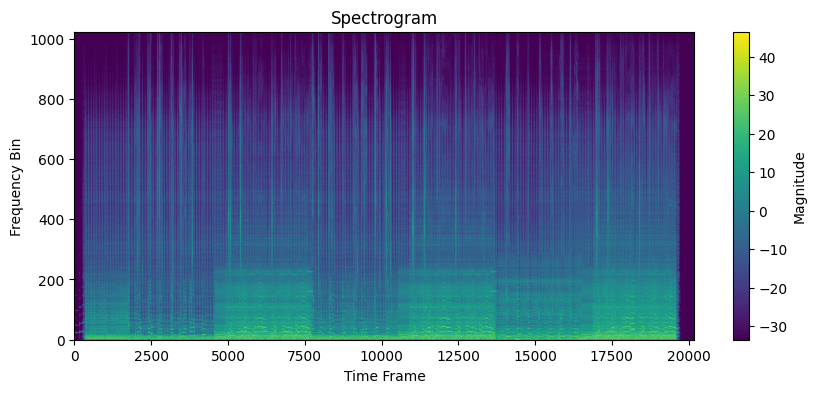

In [ ]:
import matplotlib.pyplot as plt

# Assuming spectrograms_mixtures is a list of spectrogram numpy arrays
spectrogram = spect_mixtures_map["050"]

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency Bin')
plt.xlabel('Time Frame')
plt.colorbar(label='Magnitude')
plt.show()